In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Joins and Data Frame builds
## Goal is to separate health outcomes from unhealthy behaviors and preventative measures

In [197]:
data = pd.read_csv('../data/cleansed/data.csv')
dataDef = pd.read_csv('../data/cleansed/data_def.csv')
locations = pd.read_csv('../data/cleansed/locations.csv')

In [198]:
data2 = data.set_index('uniqueid').join(locations.set_index('uniqueid')['geographiclevel']).copy()
data2 = data2[data2['geographiclevel'] == 'Census Tract']
data2 = data2.drop(['Unnamed: 0','datavaluetypeid','geographiclevel'],axis=1).reset_index()

In [199]:
dataMelt = data2.melt(id_vars=['uniqueid','populationcount'],var_name='measureid')

In [202]:
dataDef2 = dataDef[['measureid','category']].drop_duplicates()

In [203]:
joined = dataMelt.set_index('measureid').join(dataDef2.set_index('measureid'),rsuffix='_def',how='left').reset_index().set_index(['uniqueid','populationcount'])

In [239]:
preventative = joined[joined['category'] == 'Prevention'].copy()
outcomes = joined[joined['category'] == 'Health Outcomes'].copy()
unhealthy = joined[(joined['category'] == 'Unhealthy Behaviors') | (joined['category'] == 'Prevention')].copy()

In [240]:
unhealthypiv = unhealthy.reset_index().pivot_table('value','uniqueid','measureid',aggfunc=np.sum)

In [241]:
outcomespiv = outcomes.reset_index().pivot_table('value','uniqueid','measureid',aggfunc=np.sum)

## Create a clustermap of behaviors and health outcomes correlations to see if there are any correlations or groups of correlations that lead to certain outcomes

/Users/danielle/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


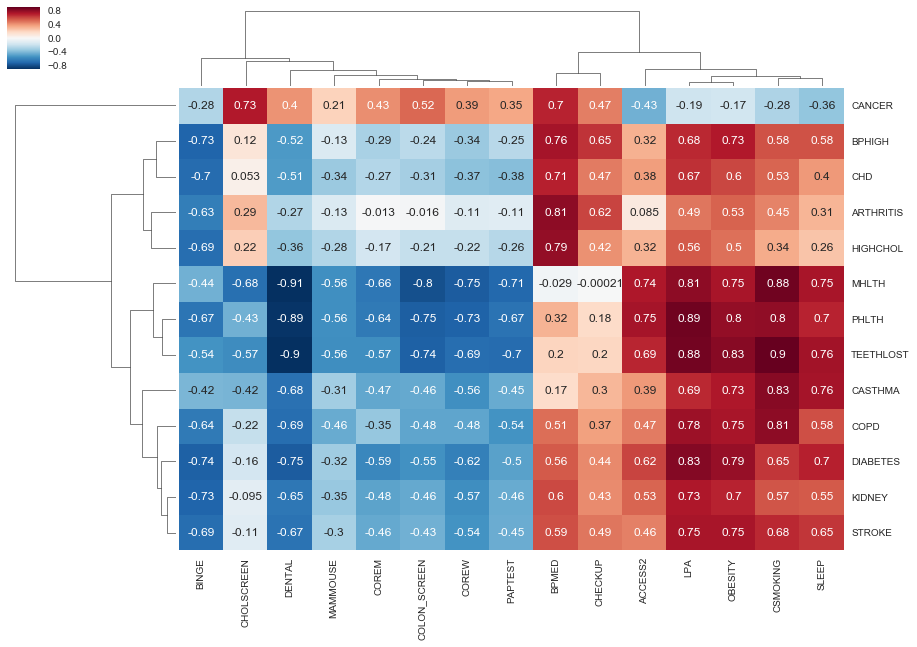

In [244]:
corrDF = []
for behavior in unhealthy.measureid.unique():
    analysis = outcomespiv.join(unhealthypiv[behavior]).copy()
    corrDF.append(analysis.corr()[behavior].to_frame())
cluster = sns.clustermap(pd.concat(corrDF,axis=1).dropna(),annot=True,figsize=(15,10))
plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.show();

Some high level takeaways:

1.) taking part in preventative measures (columns CHOLSCREEN to and including BPMED) seems to show an inverse correlation to most health measures. There are two exceptions: 
    - Taking blood pressure medication is correlated with most health outcomes. This is probably because if someone is already taking BP medication they already have some health issues.
    - Preventative measures are somewhat correlated with incidences of cancer. This could be due to have screening means you catch the disease while not getting the screenings means you do not

2.) Binge drinking seems to be inversely correlated with all health outcomes. This comes as a surprise to me.
3.) Lack of sleep, Low physical activity, and having obesity all seem to highly correlate with health outcomes, especially poor mental health, physical health, and teeth loss.

I think there is some collinearity in LPA, Obesity, and C

/Users/danielle/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


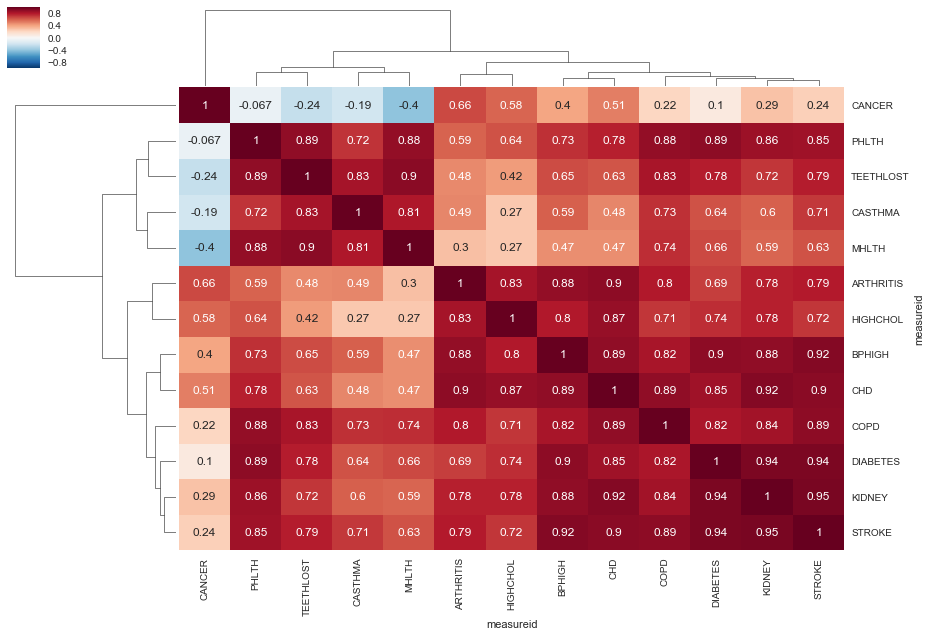

In [251]:

cluster = sns.clustermap(outcomespiv.corr(),annot=True,figsize=(15,10))
plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.show();

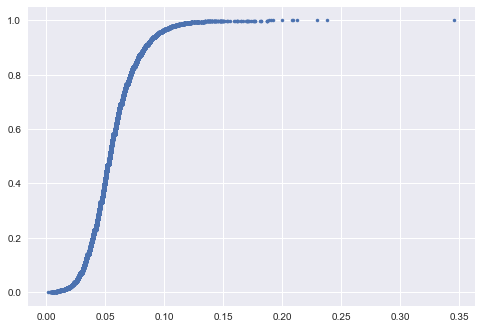

In [263]:
n = len(outcomespiv.CHD)
x = sorted(outcomespiv.CHD)
y = np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
plt.show()